In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/DL_PROJECT_DATASET/Final_Dataset'
print("Classes:", os.listdir(dataset_path))

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    print(cls, ":", len(os.listdir(cls_path)))

Classes: ['tree', 'building', 'car', 'lab', 'person']
tree : 573
building : 368
car : 556
lab : 447
person : 419


In [4]:
img_size = (224,224)
batch_size = 32
seed = 42

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.30,
    subset="training",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

temp_ds = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.30,
    subset="validation",
    seed=seed,
    image_size=img_size,
    batch_size=batch_size
)

temp_batches = tf.data.experimental.cardinality(temp_ds).numpy()
val_batches = temp_batches // 2

val_ds = temp_ds.take(val_batches)
test_ds = temp_ds.skip(val_batches)

class_names = train_ds.class_names
print(class_names)


Found 2363 files belonging to 5 classes.
Using 1655 files for training.
Found 2363 files belonging to 5 classes.
Using 708 files for validation.
['building', 'car', 'lab', 'person', 'tree']


In [5]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.map(lambda x,y:(x, tf.one_hot(y,5)))
val_ds   = val_ds.map(lambda x,y:(x, tf.one_hot(y,5)))
test_ds  = test_ds.map(lambda x,y:(x, tf.one_hot(y,5)))

def preprocess(image, label):
    return preprocess_input(image), label

train_ds = train_ds.map(preprocess).prefetch(AUTOTUNE)
val_ds   = val_ds.map(preprocess).prefetch(AUTOTUNE)
test_ds  = test_ds.map(preprocess).prefetch(AUTOTUNE)

In [6]:
from tensorflow.keras import layers
from tensorflow.keras import backend as K

def cbam_block(x, ratio=8):
    channel = x.shape[-1]

    # =====================
    # Channel Attention
    # =====================
    avg_pool = layers.GlobalAveragePooling2D()(x)
    max_pool = layers.GlobalMaxPooling2D()(x)

    shared_dense_1 = layers.Dense(channel // ratio, activation='relu')
    shared_dense_2 = layers.Dense(channel)

    avg_out = shared_dense_2(shared_dense_1(avg_pool))
    max_out = shared_dense_2(shared_dense_1(max_pool))

    ca = layers.Add()([avg_out, max_out])
    ca = layers.Activation('sigmoid')(ca)
    ca = layers.Reshape((1, 1, channel))(ca)

    x = layers.Multiply()([x, ca])

    # =====================
    # Spatial Attention
    # =====================
    avg_pool = layers.Lambda(lambda x: K.mean(x, axis=-1, keepdims=True))(x)
    max_pool = layers.Lambda(lambda x: K.max(x, axis=-1, keepdims=True))(x)

    sa = layers.Concatenate(axis=-1)([avg_pool, max_pool])
    sa = layers.Conv2D(1, kernel_size=7, padding='same', activation='sigmoid')(sa)

    x = layers.Multiply()([x, sa])

    return x

In [9]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False

x = base_model.output
x = cbam_block(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_cbam = models.Model(inputs=base_model.input, outputs=outputs)
model_cbam.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,467,115 (17.04 MB)

 Trainable params: 417,544 (1.59 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
x = base_model.output
x = cbam_block(x)        # ✅
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(5, activation='softmax')(x)

model = models.Model(inputs=base_model.input, outputs=outputs)

In [11]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_ds, validation_data=val_ds, epochs=25)



Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 472s 9s/step - accuracy: 0.7532 - loss: 0.8648 - val_accuracy: 0.9318 - val_loss: 0.2644
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 316s 6s/step - accuracy: 0.9486 - loss: 0.2198 - val_accuracy: 0.9545 - val_loss: 0.1784
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 313s 6s/step - accuracy: 0.9645 - loss: 0.1458 - val_accuracy: 0.9460 - val_loss: 0.1570
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 314s 6s/step - accuracy: 0.9749 - loss: 0.1134 - val_accuracy: 0.9574 - val_loss: 0.1428
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 295s 6s/step - accuracy: 0.9702 - loss: 0.1053 - val_accuracy: 0.9489 - val_loss: 0.1682
Epoch 6/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 342s 7s/step - accuracy: 0.9798 - loss: 0.0804 - val_accuracy: 0.9602 - val_loss: 0.1371
Epoch 7/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 306s 6s/step - accuracy: 0.9857 - loss: 0.0594 - val_accuracy: 0.9773 - val_loss: 0.0947
Epoch 8/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 341s 7s/step - accuracy: 0.9895 - loss: 0.0422 - val_accuracy: 0.9574 - v

In [13]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print(classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=2
))


              precision    recall  f1-score   support

    building       0.94      1.00      0.97        46
         car       0.96      0.96      0.96        81
         lab       0.97      0.99      0.98        78
      person       0.96      0.99      0.97        67
        tree       1.00      0.93      0.96        84

    accuracy                           0.97       356
   macro avg       0.97      0.97      0.97       356
weighted avg       0.97      0.97      0.97       356



In [14]:
y_true, y_pred = [], []

for x,y in test_ds:
    preds = model.predict(x, verbose=0)
    y_true.extend(np.argmax(y.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print("Test Accuracy:", np.mean(np.array(y_true)==np.array(y_pred)))
print(classification_report(y_true, y_pred, target_names=class_names))

Test Accuracy: 0.9578651685393258
              precision    recall  f1-score   support

    building       0.85      0.95      0.90        42
         car       0.96      0.95      0.96        85
         lab       0.97      1.00      0.99        71
      person       0.97      0.97      0.97        73
        tree       0.99      0.92      0.95        85

    accuracy                           0.96       356
   macro avg       0.95      0.96      0.95       356
weighted avg       0.96      0.96      0.96       356



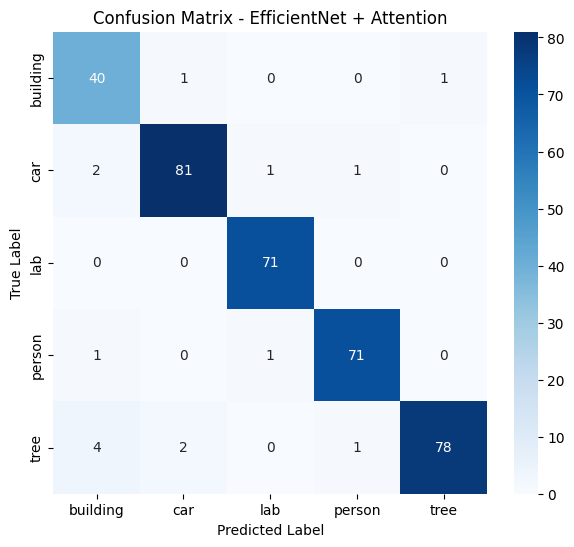

In [15]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7,6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - EfficientNet + Attention")
plt.show()


In [16]:
model.save('/content/drive/MyDrive/efficientnet_b0_cbam.keras')
print("✅ CBAM model saved successfully!")


✅ CBAM model saved successfully!


In [17]:
import os
os.listdir('/content/drive/MyDrive')

['Colab Notebooks',
 'DL_PROJECT_DATASET',
 'efficientnet_b0_final.keras',
 'efficientnet_b0_training_strategy.keras',
 'efficientnet_b0_coord.keras',
 'efficientnet_b0_cbam.keras']

In [ ]:
model.save('/content/drive/MyDrive/efficientnet_b0_cbam.keras')
print("✅ CBAM model saved successfully!")
